In [1]:
from keypress_recognition.models import black_key_model as bmodel
from keypress_recognition import dataset
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
dataset.load_all_data(train=100, test=20, val=10)

# of X_train: 100
# of X_test: 20
# of X_val: 10


In [3]:
def visualize_keys(note):
    """
    note: bool
    return: str
    """
    return ("Pressed" if note else "Not Pressed")
visualize_keys(True)

'Pressed'

Samples from X_train: 


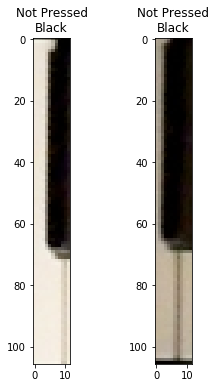

Samples from X_test: 


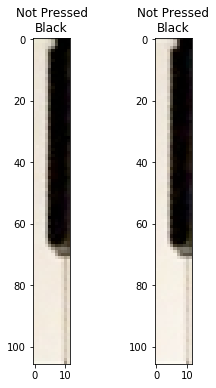

Samples from X_val: 


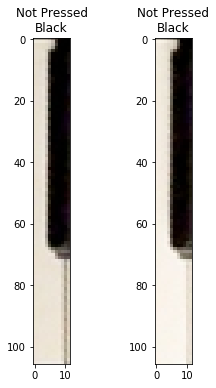

In [9]:
# print several images with labels

for _type in ['train', 'test', 'val']:

    print(f'Samples from X_{_type}: ')

    fig, axarr = plt.subplots(1, 2, figsize=[4, 6])

    for i in range(0, 2):
        _, imgb, _, noteb = dataset.get_sample(_type, method=0)
        axarr[i].imshow(imgb[0])
        axarr[i].set_title(visualize_keys(noteb[0]) + '\nBlack')

    plt.show()

In [5]:
bmodel.train(dataset, batch_size=32, num_epochs=20,
                     learning_rate=1e-3,
                     best_path='keypress_recognition/best_black_model.tar',
                     current_path='keypress_recognition/current_black.tar',
                     method=0, key_type='black')

Epoch 1/20


IntProgress(value=0)

train Loss: 0.4453
Precision: 0.02
Recall   : 0.94


IntProgress(value=0, max=10)

val Loss: 2.4455
Precision: 0.01
Recall   : 0.93
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 2/20


IntProgress(value=0)

train Loss: 0.2712
Precision: 0.02
Recall   : 1.00


IntProgress(value=0, max=10)

val Loss: 6.0871
Precision: 0.01
Recall   : 1.00
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 3/20


IntProgress(value=0)

train Loss: 0.1661
Precision: 0.02
Recall   : 1.00


IntProgress(value=0, max=10)

val Loss: 8.8065
Precision: 0.01
Recall   : 1.00
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 4/20


IntProgress(value=0)

train Loss: 0.1263
Precision: 0.02
Recall   : 1.00


IntProgress(value=0, max=10)

val Loss: 10.0831
Precision: 0.01
Recall   : 1.00
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 5/20


IntProgress(value=0)

train Loss: 0.1157
Precision: 0.02
Recall   : 1.00


IntProgress(value=0, max=10)

val Loss: 9.9570
Precision: 0.01
Recall   : 1.00
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 6/20


IntProgress(value=0)

train Loss: 0.1081
Precision: 0.02
Recall   : 1.00


IntProgress(value=0, max=10)

val Loss: 8.3624
Precision: 0.01
Recall   : 1.00
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 7/20


IntProgress(value=0)

train Loss: 0.1003
Precision: 0.02
Recall   : 0.99


IntProgress(value=0, max=10)

val Loss: 6.3752
Precision: 0.01
Recall   : 1.00
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 8/20


IntProgress(value=0)

train Loss: 0.0983
Precision: 0.02
Recall   : 0.89


IntProgress(value=0, max=10)

val Loss: 3.7990
Precision: 0.01
Recall   : 0.86
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 9/20


IntProgress(value=0)

train Loss: 0.0932
Precision: 0.02
Recall   : 0.51


IntProgress(value=0, max=10)

val Loss: 2.4272
Precision: 0.01
Recall   : 0.44
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 10/20


IntProgress(value=0)

train Loss: 0.0914
Precision: 0.02
Recall   : 0.23


IntProgress(value=0, max=10)

val Loss: 1.3582
Precision: 0.01
Recall   : 0.20
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 11/20


IntProgress(value=0)

train Loss: 0.0909
Precision: 0.02
Recall   : 0.09


IntProgress(value=0, max=10)

val Loss: 0.7094
Precision: 0.01
Recall   : 0.05
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 12/20


IntProgress(value=0)

train Loss: 0.0905
Precision: 0.02
Recall   : 0.02


IntProgress(value=0, max=10)

val Loss: 0.3850
Precision: 0.01
Recall   : 0.01
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 13/20


IntProgress(value=0)

train Loss: 0.0902
Precision: 0.02
Recall   : 0.01


IntProgress(value=0, max=10)

val Loss: 0.2393
Precision: 0.01
Recall   : 0.00
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 14/20


IntProgress(value=0)

train Loss: 0.0900
Precision: 0.02
Recall   : 0.00


IntProgress(value=0, max=10)

val Loss: 0.1753
Precision: -1.00
Recall   : 0.00
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 15/20


IntProgress(value=0)

train Loss: 0.0897
Precision: 0.02
Recall   : 0.00


IntProgress(value=0, max=10)

val Loss: 0.1465
Precision: -1.00
Recall   : 0.00
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 16/20


IntProgress(value=0)

train Loss: 0.0894
Precision: 0.02
Recall   : 0.00


IntProgress(value=0, max=10)

val Loss: 0.1328
Precision: -1.00
Recall   : 0.00
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 17/20


IntProgress(value=0)

train Loss: 0.0891
Precision: 0.02
Recall   : 0.00


IntProgress(value=0, max=10)

val Loss: 0.1254
Precision: -1.00
Recall   : 0.00
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 18/20


IntProgress(value=0)

train Loss: 0.0888
Precision: 0.02
Recall   : 0.00


IntProgress(value=0, max=10)

val Loss: 0.1208
Precision: -1.00
Recall   : 0.00
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 19/20


IntProgress(value=0)

train Loss: 0.0886
Precision: 0.02
Recall   : 0.00


IntProgress(value=0, max=10)

val Loss: 0.1174
Precision: -1.00
Recall   : 0.00
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 20/20


IntProgress(value=0)

train Loss: 0.0884
Precision: 0.02
Recall   : 0.00


IntProgress(value=0, max=10)

val Loss: 0.1150
Precision: -1.00
Recall   : 0.00
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Training complete in 1m 24s
Best val loss: 0.115042


Ground Truth: False
Predict:      Pressed


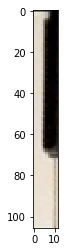

In [28]:
_, Xb, _, yb = dataset.get_sample('train', method=0)
plt.imshow(Xb[0])

Xb = np.transpose(np.array(Xb), (0, 3, 1, 2))
yb_pred = bmodel.evaluate(torch.Tensor(Xb).cuda())[0]
print("Ground Truth:", yb[0])
print("Predict:     ", visualize_keys(yb_pred))

plt.show()